In [6]:
# ML Pipeline - Image Classification with CIFAR-10
# Complete Jupyter Notebook Implementation


In [7]:

# ============================================
# 1. IMPORT LIBRARIES
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pickle
import os
from datetime import datetime

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPU Available: []


In [8]:
# 2. DATA ACQUISITION

print("\n=== DATA ACQUISITION ===")

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")


=== DATA ACQUISITION ===
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 47s 0us/step
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



=== EXPLORATORY DATA ANALYSIS ===


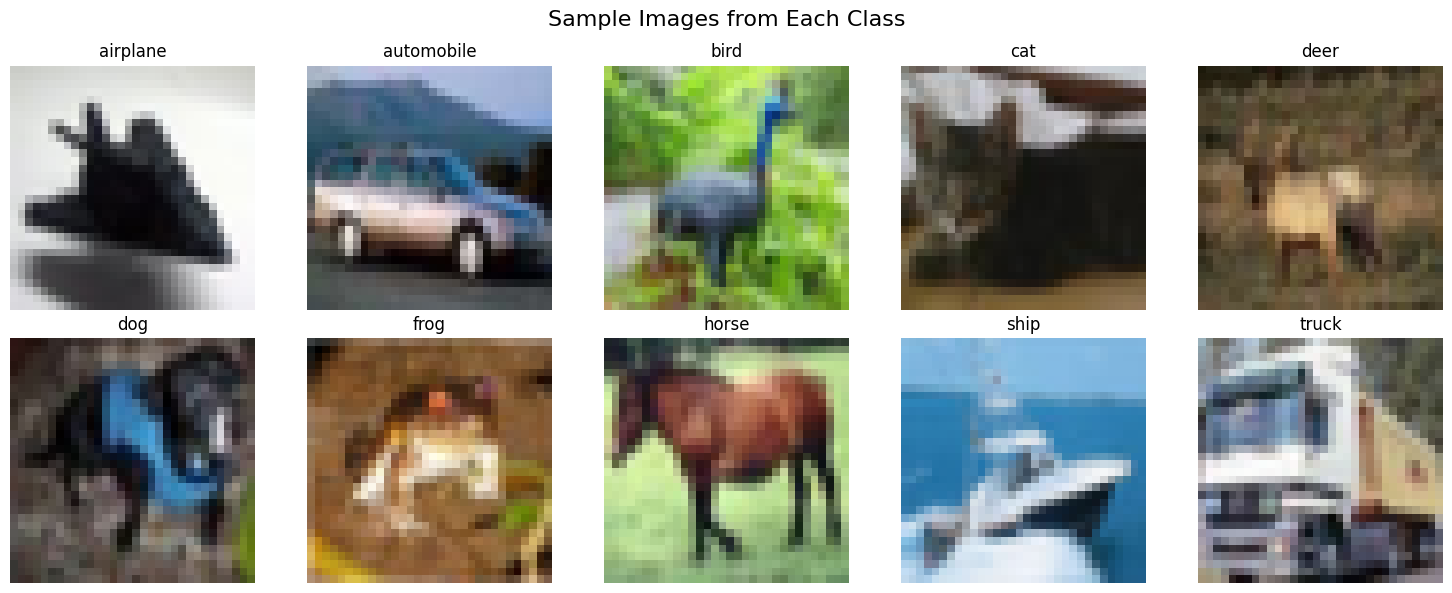

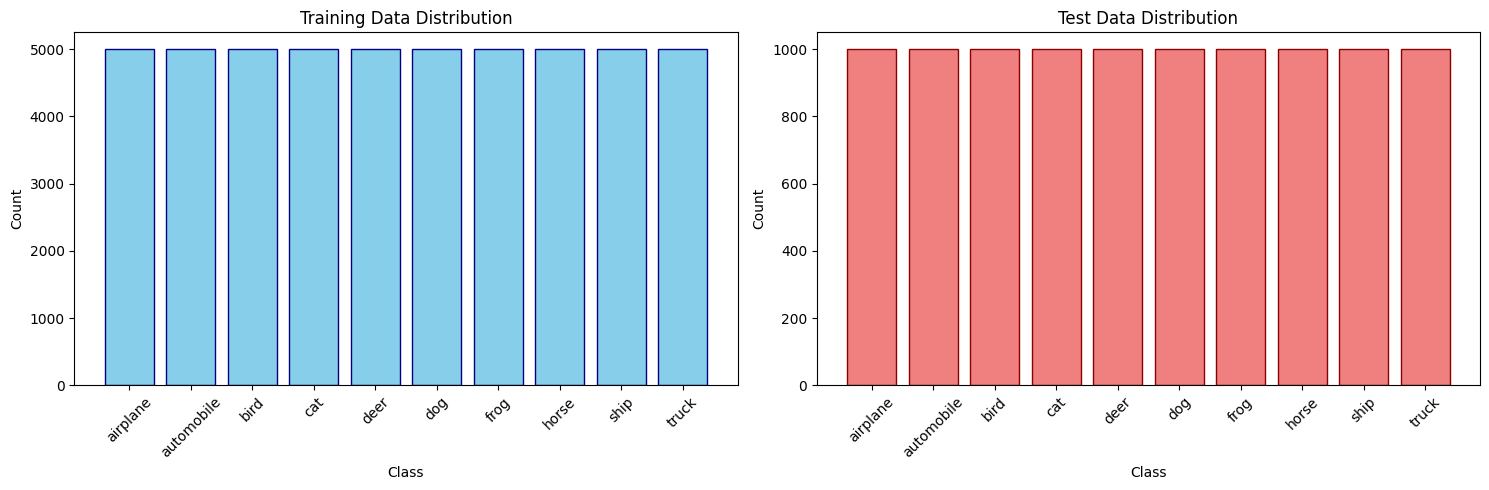

Training samples per class: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
Test samples per class: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


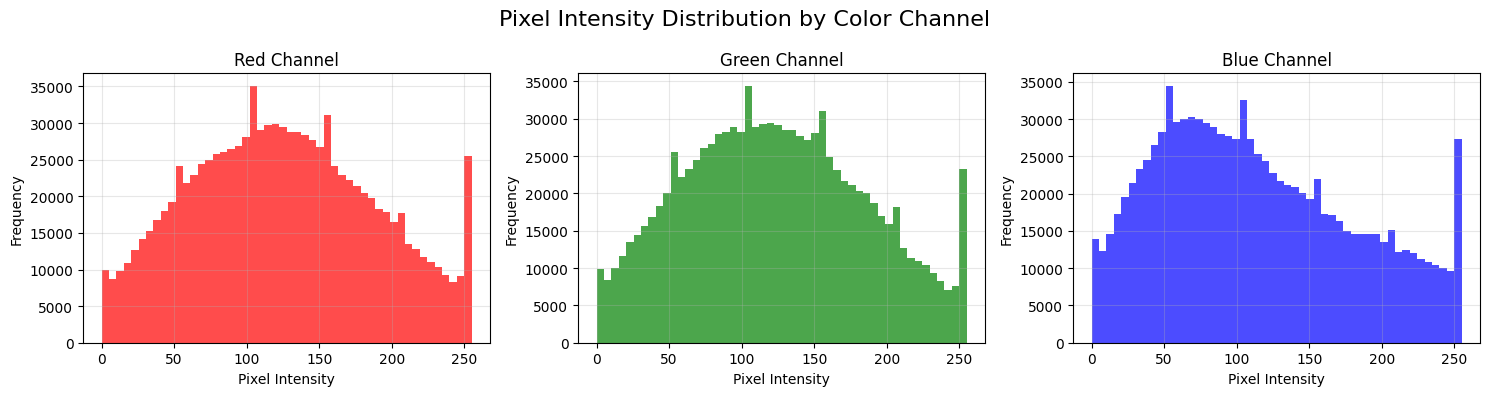

In [9]:
# 3. EXPLORATORY DATA ANALYSIS

print("\n=== EXPLORATORY DATA ANALYSIS ===")

# Visualization 1: Sample Images from Each Class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Images from Each Class', fontsize=16)
for i, ax in enumerate(axes.flat):
    idx = np.where(y_train == i)[0][0]
    ax.imshow(X_train[idx])
    ax.set_title(class_names[i])
    ax.axis('off')
plt.tight_layout()
plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

# Visualization 2: Class Distribution
train_class_counts = np.bincount(y_train.flatten())
test_class_counts = np.bincount(y_test.flatten())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training distribution
ax1.bar(class_names, train_class_counts, color='skyblue', edgecolor='navy')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_title('Training Data Distribution')
ax1.tick_params(axis='x', rotation=45)

# Test distribution
ax2.bar(class_names, test_class_counts, color='lightcoral', edgecolor='darkred')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_title('Test Data Distribution')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Training samples per class: {train_class_counts}")
print(f"Test samples per class: {test_class_counts}")

# Visualization 3: Pixel Intensity Distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Pixel Intensity Distribution by Color Channel', fontsize=16)

colors = ['red', 'green', 'blue']
channels = ['Red', 'Green', 'Blue']

for i, (ax, color, channel) in enumerate(zip(axes, colors, channels)):
    ax.hist(X_train[:1000, :, :, i].flatten(), bins=50, color=color, alpha=0.7)
    ax.set_xlabel('Pixel Intensity')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{channel} Channel')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pixel_intensity_distribution.png', dpi=150, bbox_inches='tight')
plt.show()


=== DATA PREPROCESSING ===
Original data range: 0 - 255
Normalized data range: 0.0 - 1.0
Original label shape: (50000, 1)
Categorical label shape: (50000, 10)


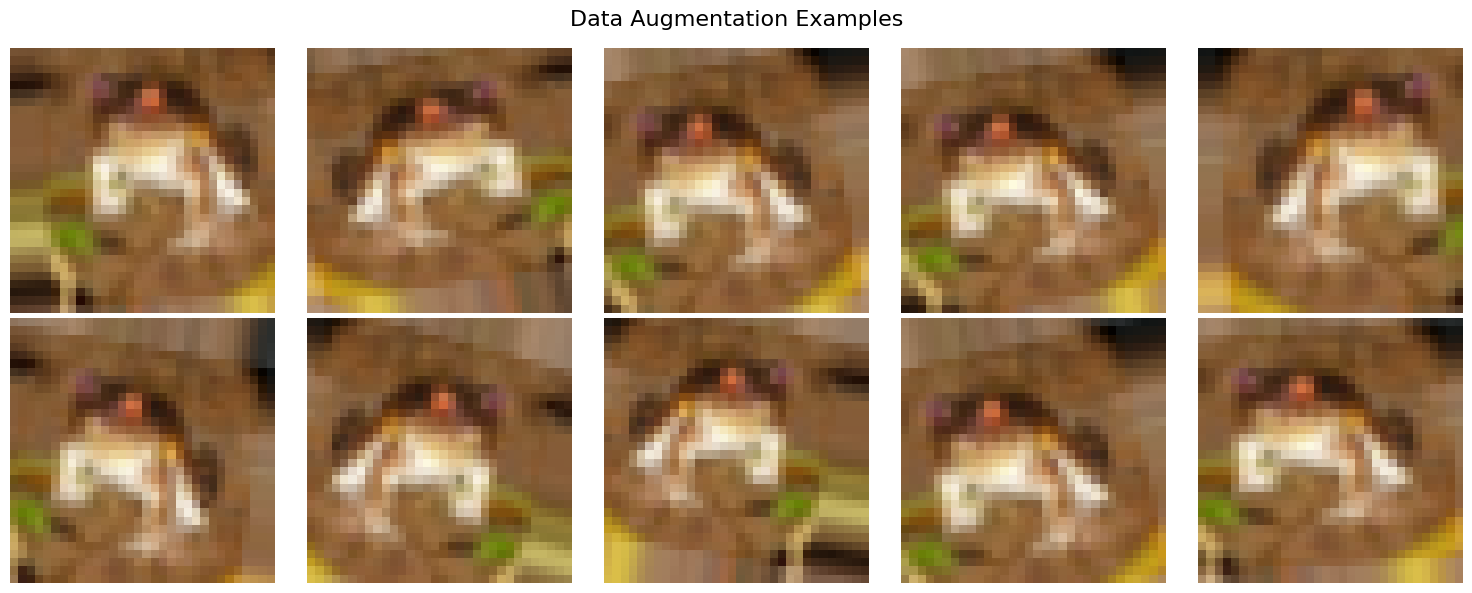

In [10]:
# 4. DATA PREPROCESSING

print("\n=== DATA PREPROCESSING ===")

# Normalize pixel values to [0, 1]
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

print("Original data range:", X_train.min(), "-", X_train.max())
print("Normalized data range:", X_train_normalized.min(), "-", X_train_normalized.max())

# Convert labels to categorical (one-hot encoding)
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

print(f"Original label shape: {y_train.shape}")
print(f"Categorical label shape: {y_train_cat.shape}")

# Data Augmentation Configuration
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Visualize augmented images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Data Augmentation Examples', fontsize=16)

sample_image = X_train_normalized[0:1]
it = datagen.flow(sample_image, batch_size=1)

for i, ax in enumerate(axes.flat):
    batch = next(it)
    ax.imshow(batch[0])
    ax.axis('off')

plt.tight_layout()
plt.savefig('data_augmentation.png', dpi=150, bbox_inches='tight')
plt.show()

In [11]:
# 5. MODEL CREATION WITH TRANSFER LEARNING

print("\n=== MODEL CREATION ===")

def create_model(input_shape=(32, 32, 3), num_classes=10):
    """
    Create a CNN model using Transfer Learning with MobileNetV2
    """
    # Load pre-trained MobileNetV2 (without top layers)
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model layers initially
    base_model.trainable = False
    
    # Build model
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        
        # Pre-trained base
        base_model,
        
        # Custom top layers
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create model
model = create_model()
model.summary()


# 6. MODEL COMPILATION & OPTIMIZATION


print("\n=== MODEL COMPILATION ===")

# Use Adam optimizer with learning rate scheduling
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

# Callbacks for optimization
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Save best model
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    
    # Reduce learning rate on plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]




=== MODEL CREATION ===


C:\Users\Hp\AppData\Local\Temp\ipykernel_23364\1968098596.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,626,762 (10.02 MB)

 Trainable params: 365,450 (1.39 MB)

 Non-trainable params: 2,261,312 (8.63 MB)


=== MODEL COMPILATION ===



=== MODEL TRAINING ===
Epoch 1/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.1797 - loss: 2.8309 - precision: 0.2465 - recall: 0.0456
Epoch 1: val_accuracy improved from None to 0.29620, saving model to best_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 66s 147ms/step - accuracy: 0.1998 - loss: 2.5787 - precision: 0.2866 - recall: 0.0434 - val_accuracy: 0.2962 - val_loss: 2.1822 - val_precision: 0.5714 - val_recall: 0.0152 - learning_rate: 0.0010
Epoch 2/50
  1/390 ━━━━━━━━━━━━━━━━━━━━ 29s 76ms/step - accuracy: 0.2109 - loss: 2.3281 - precision: 0.4615 - recall: 0.0469

c:\Users\Hp\Documents\as\MLOP_Summative\env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.29620 to 0.29650, saving model to best_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.2109 - loss: 2.3281 - precision: 0.4615 - recall: 0.0469 - val_accuracy: 0.2965 - val_loss: 2.1815 - val_precision: 0.5763 - val_recall: 0.0151 - learning_rate: 0.0010
Epoch 3/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2339 - loss: 2.3106 - precision: 0.3833 - recall: 0.0328
Epoch 3: val_accuracy improved from 0.29650 to 0.31160, saving model to best_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 64s 165ms/step - accuracy: 0.2361 - loss: 2.2896 - precision: 0.3856 - recall: 0.0287 - val_accuracy: 0.3116 - val_loss: 2.1093 - val_precision: 0.5590 - val_recall: 0.0303 - learning_rate: 0.0010
Epoch 4/50
  1/390 ━━━━━━━━━━━━━━━━━━━━ 41s 106ms/step - accuracy: 0.2578 - loss: 2.2196 - precision: 0.6000 - recall: 0.0234
Epoch 4: val_accuracy improved from 0.31160 to 0.31230, saving model to best_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.2578 - loss: 2.2196 - precision: 0.6000 - recall: 0.0234 - val_accuracy: 0.3123 - val_loss: 2.1096 - val_precision: 0.5612 - val_recall: 0.0307 - learning_rate: 0.0010
Epoch 5/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.2494 - loss: 2.2151 - precision: 0.4557 - recall: 0.0232
Epoch 5: val_accuracy did not improve from 0.31230
390/390 ━━━━━━━━━━━━━━━━━━━━ 87s 224ms/step - accuracy: 0.2533 - loss: 2.1972 - precision: 0.4674 - recall: 0.0235 - val_accuracy: 0.3070 - val_loss: 2.0565 - val_precision: 0.5864 - val_recall: 0.0275 - learning_rate: 0.0010
Epoch 6/50
  1/390 ━━━━━━━━━━━━━━━━━━━━ 38s 99ms/step - accuracy: 0.2969 - loss: 2.0503 - precision: 0.6667 - recall: 0.0156
Epoch 6: val_accuracy did not improve from 0.31230
390/390 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.2969 - loss: 2.0503 - precision: 0.6667 - recall: 0.0156 - val_accuracy: 0.3067 - val_loss: 2.0569 - val_precision: 0.5897 - val_recall: 0.0

390/390 ━━━━━━━━━━━━━━━━━━━━ 106s 271ms/step - accuracy: 0.2595 - loss: 2.1425 - precision: 0.5038 - recall: 0.0227 - val_accuracy: 0.3214 - val_loss: 2.0151 - val_precision: 0.6387 - val_recall: 0.0251 - learning_rate: 0.0010
Epoch 8/50
  1/390 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - accuracy: 0.2734 - loss: 2.0082 - precision: 0.5000 - recall: 0.0234
Epoch 8: val_accuracy did not improve from 0.32140
390/390 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.2734 - loss: 2.0082 - precision: 0.5000 - recall: 0.0234 - val_accuracy: 0.3205 - val_loss: 2.0145 - val_precision: 0.6400 - val_recall: 0.0256 - learning_rate: 0.0010
Epoch 9/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.2675 - loss: 2.1065 - precision: 0.5026 - recall: 0.0225
Epoch 9: val_accuracy improved from 0.32140 to 0.32440, saving model to best_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 75s 193ms/step - accuracy: 0.2643 - loss: 2.1051 - precision: 0.5088 - recall: 0.0220 - val_accuracy: 0.3244 - val_loss: 1.9831 - val_precision: 0.6270 - val_recall: 0.0306 - learning_rate: 0.0010
Epoch 10/50
  1/390 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.2266 - loss: 2.2009 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 10: val_accuracy did not improve from 0.32440
390/390 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.2266 - loss: 2.2009 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3232 - val_loss: 1.9834 - val_precision: 0.6240 - val_recall: 0.0302 - learning_rate: 0.0010
Epoch 11/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.2647 - loss: 2.0831 - precision: 0.5157 - recall: 0.0221
Epoch 11: val_accuracy improved from 0.32440 to 0.32550, saving model to best_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 80s 205ms/step - accuracy: 0.2661 - loss: 2.0759 - precision: 0.5307 - recall: 0.0245 - val_accuracy: 0.3255 - val_loss: 1.9604 - val_precision: 0.5951 - val_recall: 0.0294 - learning_rate: 0.0010
Epoch 12/50
  1/390 ━━━━━━━━━━━━━━━━━━━━ 55s 144ms/step - accuracy: 0.2734 - loss: 2.0407 - precision: 0.4000 - recall: 0.0156
Epoch 12: val_accuracy improved from 0.32550 to 0.32590, saving model to best_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.2734 - loss: 2.0407 - precision: 0.4000 - recall: 0.0156 - val_accuracy: 0.3259 - val_loss: 1.9610 - val_precision: 0.6050 - val_recall: 0.0291 - learning_rate: 0.0010
Epoch 13/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.2709 - loss: 2.0559 - precision: 0.5388 - recall: 0.0245
Epoch 13: val_accuracy did not improve from 0.32590
390/390 ━━━━━━━━━━━━━━━━━━━━ 130s 332ms/step - accuracy: 0.2674 - loss: 2.0600 - precision: 0.5254 - recall: 0.0228 - val_accuracy: 0.3135 - val_loss: 1.9511 - val_precision: 0.6101 - val_recall: 0.0352 - learning_rate: 0.0010
Epoch 14/50
  1/390 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - accuracy: 0.3125 - loss: 2.0499 - precision: 0.2857 - recall: 0.0156
Epoch 14: val_accuracy did not improve from 0.32590
390/390 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.3125 - loss: 2.0499 - precision: 0.2857 - recall: 0.0156 - val_accuracy: 0.3140 - val_loss: 1.9511 - val_precision: 0.6167 - val_recal

390/390 ━━━━━━━━━━━━━━━━━━━━ 155s 397ms/step - accuracy: 0.2670 - loss: 2.0422 - precision: 0.5311 - recall: 0.0219 - val_accuracy: 0.3266 - val_loss: 1.9391 - val_precision: 0.6320 - val_recall: 0.0261 - learning_rate: 0.0010
Epoch 18/50
  1/390 ━━━━━━━━━━━━━━━━━━━━ 43s 111ms/step - accuracy: 0.2578 - loss: 2.0564 - precision: 0.7500 - recall: 0.0234
Epoch 18: val_accuracy did not improve from 0.32660
390/390 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.2578 - loss: 2.0564 - precision: 0.7500 - recall: 0.0234 - val_accuracy: 0.3264 - val_loss: 1.9390 - val_precision: 0.6374 - val_recall: 0.0269 - learning_rate: 0.0010
Epoch 19/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.2712 - loss: 2.0481 - precision: 0.5303 - recall: 0.0209
Epoch 19: val_accuracy improved from 0.32660 to 0.33160, saving model to best_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 100s 255ms/step - accuracy: 0.2684 - loss: 2.0452 - precision: 0.5328 - recall: 0.0212 - val_accuracy: 0.3316 - val_loss: 1.9262 - val_precision: 0.6151 - val_recall: 0.0358 - learning_rate: 0.0010
Epoch 20/50
  1/390 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.2812 - loss: 1.9874 - precision: 0.8571 - recall: 0.0469
Epoch 20: val_accuracy did not improve from 0.33160
390/390 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.2812 - loss: 1.9874 - precision: 0.8571 - recall: 0.0469 - val_accuracy: 0.3297 - val_loss: 1.9263 - val_precision: 0.6192 - val_recall: 0.0361 - learning_rate: 0.0010
Epoch 21/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.2700 - loss: 2.0398 - precision: 0.5488 - recall: 0.0237
Epoch 21: val_accuracy did not improve from 0.33160
390/390 ━━━━━━━━━━━━━━━━━━━━ 69s 176ms/step - accuracy: 0.2696 - loss: 2.0386 - precision: 0.5416 - recall: 0.0226 - val_accuracy: 0.3293 - val_loss: 1.9227 - val_precision: 0.6317 - val_reca

390/390 ━━━━━━━━━━━━━━━━━━━━ 85s 218ms/step - accuracy: 0.2721 - loss: 2.0255 - precision: 0.5499 - recall: 0.0228 - val_accuracy: 0.3360 - val_loss: 1.9040 - val_precision: 0.6687 - val_recall: 0.0333 - learning_rate: 5.0000e-04
Epoch 28/50
  1/390 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - accuracy: 0.3516 - loss: 1.8891 - precision: 1.0000 - recall: 0.0312
Epoch 28: val_accuracy improved from 0.33600 to 0.33620, saving model to best_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.3516 - loss: 1.8891 - precision: 1.0000 - recall: 0.0312 - val_accuracy: 0.3362 - val_loss: 1.9042 - val_precision: 0.6673 - val_recall: 0.0337 - learning_rate: 5.0000e-04
Epoch 29/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.2743 - loss: 2.0165 - precision: 0.5536 - recall: 0.0234
Epoch 29: val_accuracy improved from 0.33620 to 0.33700, saving model to best_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 63s 159ms/step - accuracy: 0.2720 - loss: 2.0241 - precision: 0.5557 - recall: 0.0223 - val_accuracy: 0.3370 - val_loss: 1.9021 - val_precision: 0.6485 - val_recall: 0.0321 - learning_rate: 5.0000e-04
Epoch 30/50
  1/390 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - accuracy: 0.2422 - loss: 2.0381 - precision: 0.5000 - recall: 0.0078
Epoch 30: val_accuracy did not improve from 0.33700
390/390 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.2422 - loss: 2.0381 - precision: 0.5000 - recall: 0.0078 - val_accuracy: 0.3368 - val_loss: 1.9022 - val_precision: 0.6546 - val_recall: 0.0326 - learning_rate: 5.0000e-04
Epoch 31/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.2760 - loss: 2.0183 - precision: 0.5400 - recall: 0.0219
Epoch 31: val_accuracy did not improve from 0.33700
390/390 ━━━━━━━━━━━━━━━━━━━━ 63s 162ms/step - accuracy: 0.2753 - loss: 2.0168 - precision: 0.5492 - recall: 0.0228 - val_accuracy: 0.3370 - val_loss: 1.8941 - val_precision: 0.6742 - val

390/390 ━━━━━━━━━━━━━━━━━━━━ 52s 134ms/step - accuracy: 0.2779 - loss: 1.9989 - precision: 0.5736 - recall: 0.0269 - val_accuracy: 0.3402 - val_loss: 1.8789 - val_precision: 0.6529 - val_recall: 0.0410 - learning_rate: 2.5000e-04
Epoch 40/50
  1/390 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step - accuracy: 0.1719 - loss: 2.0884 - precision: 0.3750 - recall: 0.0234
Epoch 40: val_accuracy did not improve from 0.34020
390/390 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.1719 - loss: 2.0884 - precision: 0.3750 - recall: 0.0234 - val_accuracy: 0.3399 - val_loss: 1.8788 - val_precision: 0.6534 - val_recall: 0.0409 - learning_rate: 2.5000e-04
Epoch 41/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.2790 - loss: 1.9960 - precision: 0.5794 - recall: 0.0268
Epoch 41: val_accuracy improved from 0.34020 to 0.34110, saving model to best_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 66s 169ms/step - accuracy: 0.2797 - loss: 1.9942 - precision: 0.5827 - recall: 0.0280 - val_accuracy: 0.3411 - val_loss: 1.8731 - val_precision: 0.6144 - val_recall: 0.0443 - learning_rate: 2.5000e-04
Epoch 42/50
  1/390 ━━━━━━━━━━━━━━━━━━━━ 51s 133ms/step - accuracy: 0.3125 - loss: 1.9846 - precision: 0.5000 - recall: 0.0234
Epoch 42: val_accuracy did not improve from 0.34110
390/390 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.3125 - loss: 1.9846 - precision: 0.5000 - recall: 0.0234 - val_accuracy: 0.3404 - val_loss: 1.8730 - val_precision: 0.6125 - val_recall: 0.0441 - learning_rate: 2.5000e-04
Epoch 43/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.2807 - loss: 1.9933 - precision: 0.5800 - recall: 0.0290
Epoch 43: val_accuracy did not improve from 0.34110
390/390 ━━━━━━━━━━━━━━━━━━━━ 59s 152ms/step - accuracy: 0.2804 - loss: 1.9949 - precision: 0.5706 - recall: 0.0278 - val_accuracy: 0.3396 - val_loss: 1.8720 - val_precision: 0.6318 - v

390/390 ━━━━━━━━━━━━━━━━━━━━ 54s 137ms/step - accuracy: 0.2820 - loss: 1.9905 - precision: 0.5673 - recall: 0.0261 - val_accuracy: 0.3460 - val_loss: 1.8662 - val_precision: 0.6392 - val_recall: 0.0443 - learning_rate: 2.5000e-04
Epoch 46/50
  1/390 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.2422 - loss: 2.0197 - precision: 0.5556 - recall: 0.0391
Epoch 46: val_accuracy improved from 0.34600 to 0.34610, saving model to best_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.2422 - loss: 2.0197 - precision: 0.5556 - recall: 0.0391 - val_accuracy: 0.3461 - val_loss: 1.8663 - val_precision: 0.6400 - val_recall: 0.0448 - learning_rate: 2.5000e-04
Epoch 47/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2846 - loss: 1.9851 - precision: 0.5688 - recall: 0.0285
Epoch 47: val_accuracy did not improve from 0.34610
390/390 ━━━━━━━━━━━━━━━━━━━━ 63s 162ms/step - accuracy: 0.2855 - loss: 1.9863 - precision: 0.5653 - recall: 0.0289 - val_accuracy: 0.3433 - val_loss: 1.8678 - val_precision: 0.6330 - val_recall: 0.0433 - learning_rate: 2.5000e-04
Epoch 48/50
  1/390 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.3047 - loss: 1.9719 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 48: val_accuracy did not improve from 0.34610
390/390 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.3047 - loss: 1.9719 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3442 - val_loss: 1.8676 - val_precisio

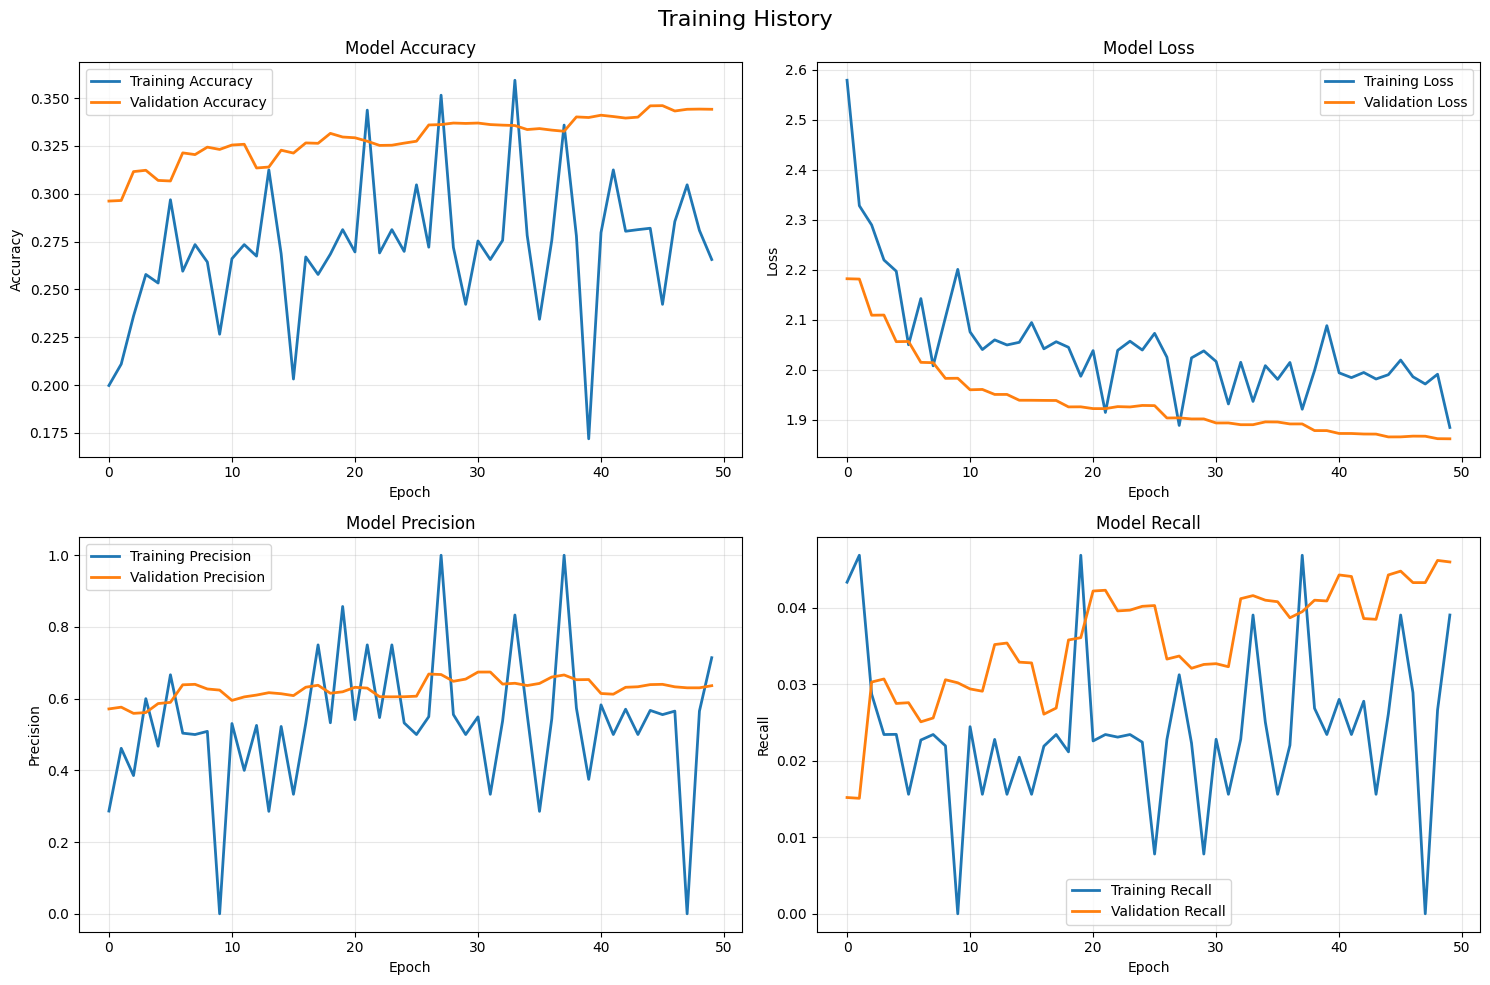

In [12]:
# 7. MODEL TRAINING

print("\n=== MODEL TRAINING ===")

batch_size = 128
epochs = 50

# Train with data augmentation
history = model.fit(
    datagen.flow(X_train_normalized, y_train_cat, batch_size=batch_size),
    steps_per_epoch=len(X_train_normalized) // batch_size,
    epochs=epochs,
    validation_data=(X_test_normalized, y_test_cat),
    callbacks=callbacks,
    verbose=1
)

# Save training history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
 

# 8. TRAINING VISUALIZATION


print("\n=== TRAINING VISUALIZATION ===")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training History', fontsize=16)

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()



=== MODEL EVALUATION ===
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step

FINAL MODEL PERFORMANCE METRICS
Accuracy:  0.3442 (34.42%)
Precision: 0.3477 (34.77%)
Recall:    0.3442 (34.42%)
F1-Score:  0.3378 (33.78%)

Detailed Classification Report:
              precision    recall  f1-score   support

    airplane       0.38      0.40      0.39      1000
  automobile       0.35      0.28      0.31      1000
        bird       0.29      0.14      0.19      1000
         cat       0.34      0.25      0.29      1000
        deer       0.44      0.34      0.38      1000
         dog       0.26      0.38      0.31      1000
        frog       0.42      0.46      0.44      1000
       horse       0.35      0.34      0.35      1000
        ship       0.34      0.32      0.33      1000
       truck       0.32      0.53      0.40      1000

    accuracy                           0.34     10000
   macro avg       0.35      0.34      0.34     10000
weighted avg       0.35      0.34      0.34     10000

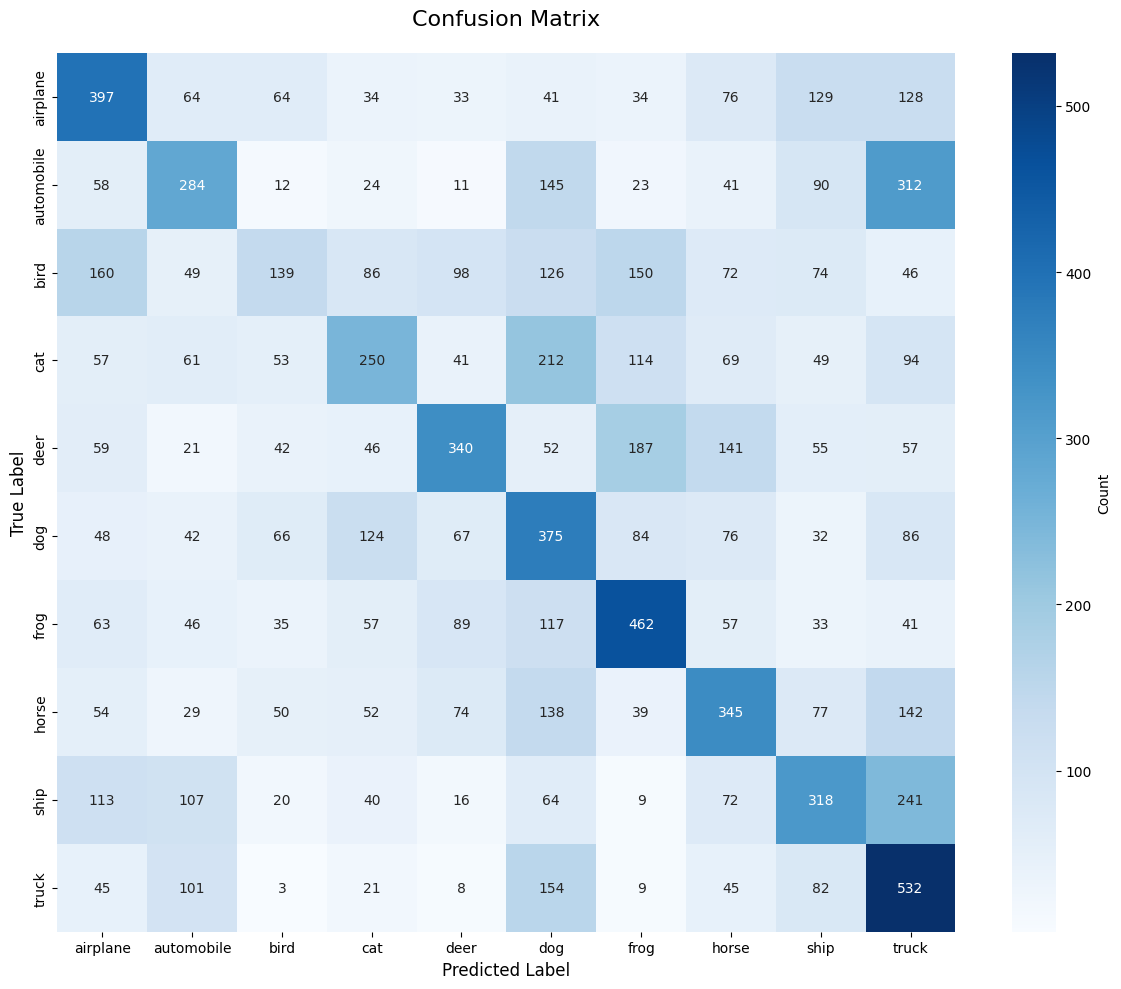

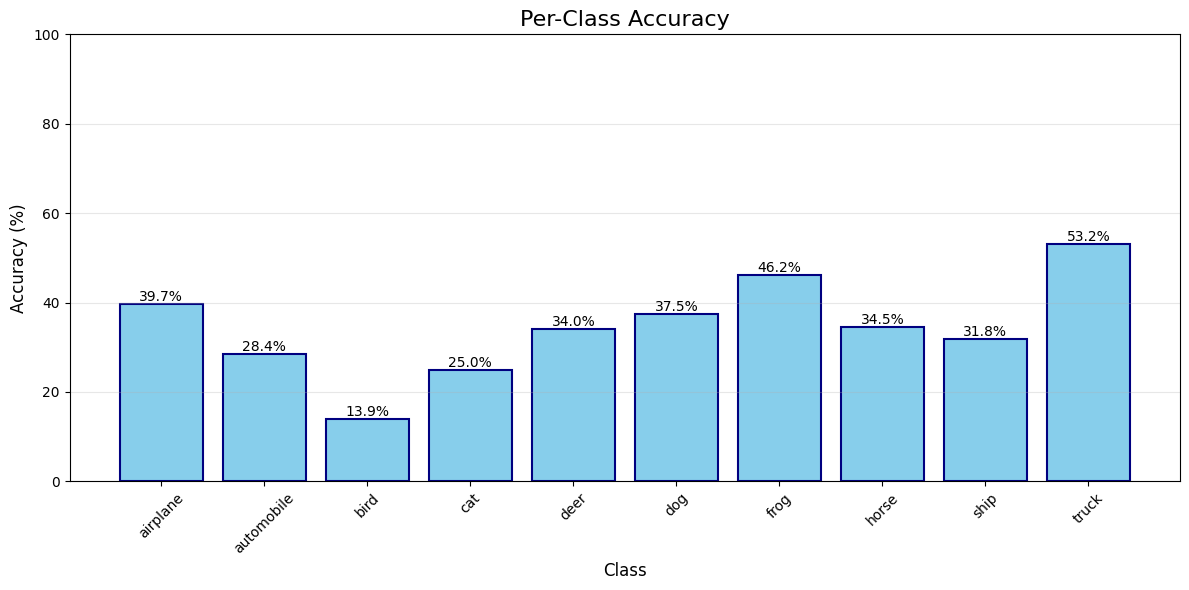

In [13]:
# 9. MODEL EVALUATION

print("\n=== MODEL EVALUATION ===")

# Predictions
y_pred_probs = model.predict(X_test_normalized)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test.flatten()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\n" + "="*50)
print("FINAL MODEL PERFORMANCE METRICS")
print("="*50)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print("="*50)

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, class_accuracy * 100, color='skyblue', edgecolor='navy', linewidth=1.5)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Per-Class Accuracy', fontsize=16)
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

for bar, acc in zip(bars, class_accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc*100:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('per_class_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

In [14]:
# 10. SAVE MODEL

print("\n=== SAVING MODEL ===")

# Save in multiple formats
model.save('cifar10_classifier.h5')
model.save('cifar10_classifier_savedmodel')

# Save metadata
metadata = {
    'class_names': class_names,
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'input_shape': (32, 32, 3),
    'num_classes': 10,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("Model saved successfully!")
print(f"Files created:")
print("  - cifar10_classifier.h5")
print("  - cifar10_classifier_savedmodel/")
print("  - model_metadata.pkl")
print("  - training_history.pkl")



=== SAVING MODEL ===


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=cifar10_classifier_savedmodel.

In [ ]:
# 11. PREDICTION FUNCTION
print("\n=== PREDICTION FUNCTION ===")

def predict_image(model, image, class_names):
    """
    Predict the class of a single image
    
    Args:
        model: Trained Keras model
        image: Image array (32, 32, 3) normalized to [0, 1]
        class_names: List of class names
    
    Returns:
        Dictionary with prediction results
    """
    # Ensure image is in correct format
    if image.shape != (32, 32, 3):
        raise ValueError(f"Image must be shape (32, 32, 3), got {image.shape}")
    
    # Add batch dimension
    image_batch = np.expand_dims(image, axis=0)
    
    # Predict
    predictions = model.predict(image_batch, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    
    # Get all class probabilities
    all_predictions = [
        {'class': class_names[i], 'confidence': float(predictions[0][i])}
        for i in range(len(class_names))
    ]
    all_predictions.sort(key=lambda x: x['confidence'], reverse=True)
    
    return {
        'predicted_class': class_names[predicted_class_idx],
        'confidence': float(confidence),
        'all_predictions': all_predictions
    }

# Test prediction function
test_idx = 0
test_image = X_test_normalized[test_idx]
result = predict_image(model, test_image, class_names)

print(f"\nTest Prediction:")
print(f"Predicted: {result['predicted_class']} (Confidence: {result['confidence']:.4f})")
print(f"Actual: {class_names[y_test[test_idx][0]]}")

# Visualize prediction
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.imshow(test_image)
ax1.set_title(f"Predicted: {result['predicted_class']}\nActual: {class_names[y_test[test_idx][0]]}")
ax1.axis('off')

top_5 = result['all_predictions'][:5]
classes = [p['class'] for p in top_5]
confidences = [p['confidence'] for p in top_5]

ax2.barh(classes, confidences, color='skyblue', edgecolor='navy')
ax2.set_xlabel('Confidence')
ax2.set_title('Top 5 Predictions')
ax2.set_xlim(0, 1)

plt.tight_layout()
plt.savefig('sample_prediction.png', dpi=150, bbox_inches='tight')
plt.show()